In [30]:
import os
import pandas as pd
import numpy as np
import warnings

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_distances

warnings.filterwarnings('ignore')

In [22]:
inputs_path = os.path.join(os.path.dirname(os.getcwd()), "data", "inputs")
delete_groups = ["Interest and Exchange Rates", "Stock Market"]
delete_series = ["ACOGNO"]

# load fred description and data
des_fred_df = pd.read_csv(os.path.join(inputs_path, 'fredmd_description.csv'), sep=";")
fred_df = pd.read_csv(os.path.join(inputs_path, 'fredmd_transf.csv'))
fred_df.set_index("date", inplace=True)

# delete groups
macro_fred = []
for colname in fred_df.columns:

    if colname not in des_fred_df["fred"].values:
        continue

    group = des_fred_df[des_fred_df["fred"] == colname]["group"].values[0]

    if (group not in delete_groups) and (colname not in delete_series):
        macro_fred.append(fred_df[colname])
macro_fred_df = pd.concat(macro_fred, axis=1)

In [23]:
# chek for missing values
macro_fred_df.apply(lambda x: x.dropna().first_valid_index()).sort_values()

RPI                1960-01-01
CONSPI             1960-01-01
NONREVSL           1960-01-01
REALLN             1960-01-01
BUSLOANS           1960-01-01
                      ...    
UEMP5TO14          1960-01-01
MANEMP             1960-01-01
DSERRG3M086SBEA    1960-01-01
ANDENOx            1968-03-01
UMCSENTx           1978-02-01
Length: 97, dtype: object

In [31]:
# parameters
k = 5

# select data
X = macro_fred_df.dropna()

# compute similarity
X_similarity = cosine_distances(X)

kmeans = KMeans(n_clusters=k, random_state=0).fit(X_similarity)
X.loc[:, "cluster"] = kmeans.labels_

melt_X = X[["cluster"]].reset_index().melt("date").drop(["variable"], axis=1)
melt_X.rename(columns={"value": "cluster"}, inplace=True)
melt_X.loc[:, "value"] = 1
melt_X.loc[:, "value"] = melt_X["value"] * melt_X["cluster"]
pivot_X = melt_X.pivot_table(index=["date"], columns=["cluster"], values=["value"])
pivot_X.index = pd.to_datetime(pivot_X.index)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


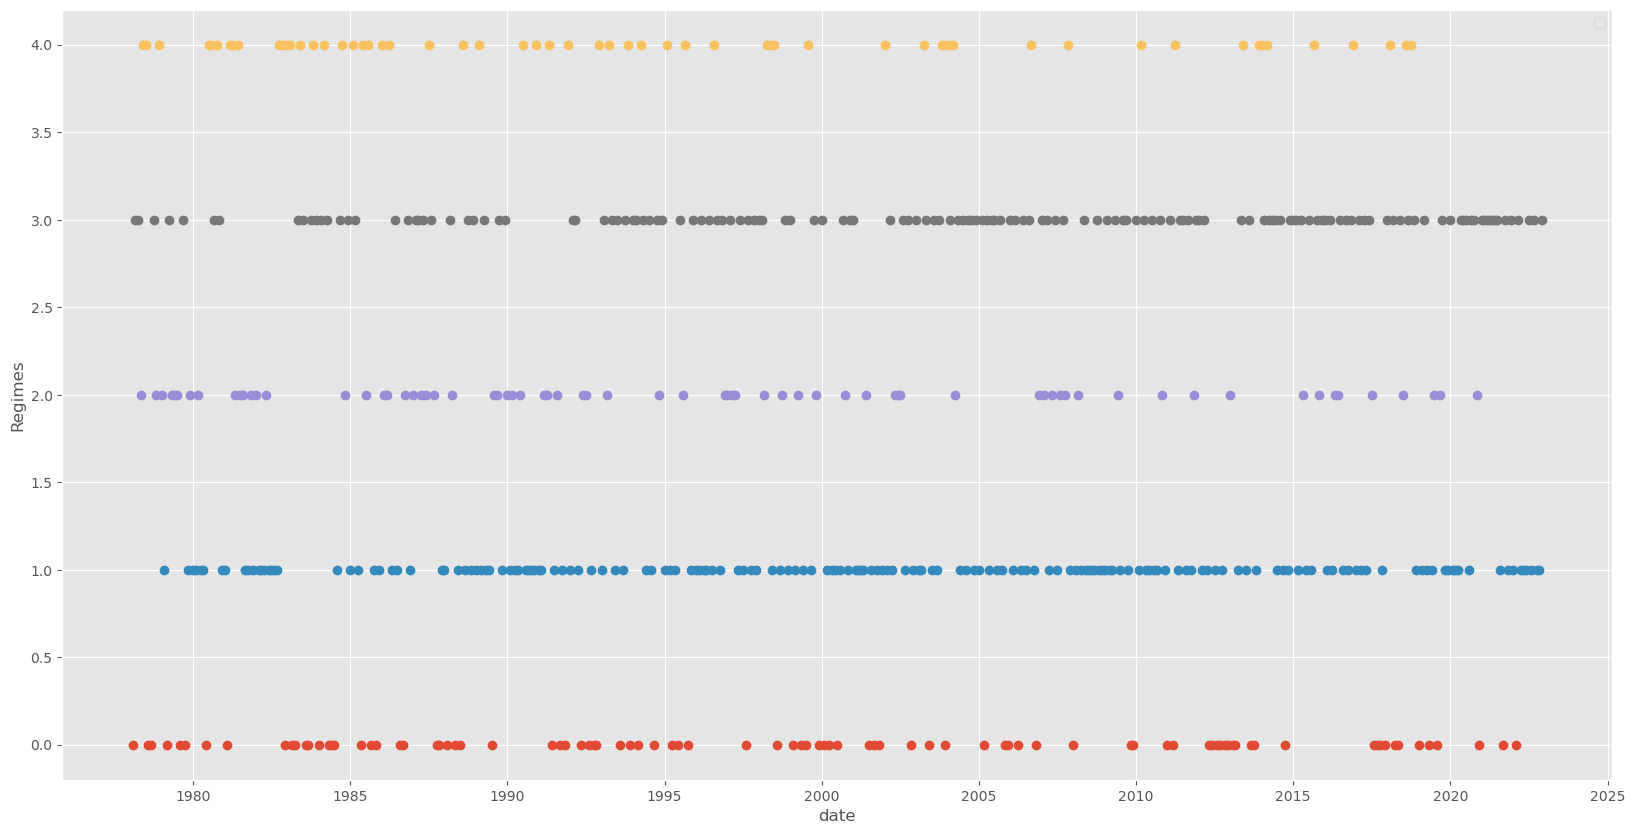

In [32]:

import matplotlib.pyplot as plt
plt.style.use("ggplot")

plt.figure(figsize=(20, 10))
plt.plot(pivot_X.index, pivot_X.values, marker="o", linestyle="")
plt.xlabel("date")
plt.ylabel("Regimes")
plt.legend()